In [1]:
# import sys
# sys.path.append('../..')

import os
os.chdir('../..')

In [2]:
import transformers
import torch
import tqdm
import io
import pickle
import glob

import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from utility.minio import cmd
from training_worker.ab_ranking.model.ab_ranking_linear import ABRankingModel
from stable_diffusion.model.clip_text_embedder import CLIPTextEmbedder
from sklearn.model_selection import train_test_split

In [3]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

minio_client = cmd.get_minio_client(
    minio_access_key='GXvqLWtthELCaROPITOG',
    minio_secret_key='DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD',
    minio_ip_addr='123.176.98.90:9000'
)

def load_model(input_size, device=DEVICE):
    # loads linear ranking model
    input_path = "environmental/models/ranking/"

    scoring_model = ABRankingModel(input_size)

    model_files = cmd.get_list_of_objects_with_prefix(minio_client, 'datasets', input_path)
    most_recent_model = None

    for model_file in model_files:
        if model_file.endswith("score-linear-embedding-positive.pth"):
            most_recent_model = model_file

    if most_recent_model:
        model_file_data = cmd.get_file_from_minio(minio_client, 'datasets', most_recent_model)
    else:
        print("No .pth files found in the list.")
        return

    # Create a BytesIO object and write the downloaded content into it
    byte_buffer = io.BytesIO()
    for data in model_file_data.stream(amt=8192):
        byte_buffer.write(data)
    # Reset the buffer's position to the beginning
    byte_buffer.seek(0)

    scoring_model.load(byte_buffer)
    scoring_model.model = scoring_model.model.to(device)

    return scoring_model

def load_clip():
    text_embedder = CLIPTextEmbedder()
    text_embedder.device = DEVICE
    text_embedder.load_submodels()

    return text_embedder, text_embedder.tokenizer

scorer = load_model(768)
clip, tokenizer = load_clip()

mean, std = scorer.mean, scorer.standard_deviation

Checking if minio server is accessible...
Connecting to minio client...
Successfully connected to minio client...
Loading tokenizer and transformer...[DONE]	750.72ms                               


In [4]:
def embed( prompt):
    # given a prompt string, this function converts it into text embedding
    with torch.no_grad():
        embedding, _, attention_mask = clip.forward_return_all(prompt)

    return embedding

def score_prompt(prompt):
    # given a prompt string, embed it into text embedding and score it using linear model
    # only considers positive prompt
    embedding = embed(prompt)
    # reshape it such that the sequence dimension is at the end
    # this is necessary for the linear model
    embedding = embedding.permute(0, 2, 1)
    score = scorer.predict_positive_or_negative_only(embedding).cpu().numpy()

    return score

# Load Dataset

In [5]:
csv_remove = sorted(glob.glob('../data/20231122_prompt_mutator/*/*remove_dataset.csv'))
# csv_add = sorted(glob.glob('../data/20231122_prompt_mutator/*/*add_dataset.csv'))

In [6]:
# quick visualization
df = pd.read_csv(csv_remove[0])
df.head()

,prompt,phrase,score,mutated_score
0,"space colonization, 2d video game concept art,...",space adventure,4650.695801,4681.410156
1,"space colonization, 2d video game concept art,...",snes,4681.410156,4548.402832
2,"space colonization, 2d video game concept art,...",snes,4681.410156,4548.402832
3,"space colonization, 2d video game concept art,...",tileset,4681.410156,4557.304199
4,"space colonization, 2d video game concept art,...",mars survival,4681.410156,4850.648438


Recompute linear scores using the latest model

In [7]:
df = []

for csv in csv_remove:
    df_tmp = pd.read_csv(csv)
    df.append(df_tmp)
df = pd.concat(df, ignore_index=True)

# remove duplicated row
df = df.drop_duplicates()

# check how many unique removed phrases are there
df['phrase'].nunique()

18638

In [8]:
batch_size = 1

def mutate_prompt(row):
    prompt, phrase = row['prompt'], row['phrase']

    prompt_split = prompt.split(', ')
    del prompt_split[prompt_split.index(phrase)]
    mutated_prompt = ', '.join(prompt_split)

    return mutated_prompt

df_new = []
for i in tqdm.tqdm(range(0, df.shape[0], batch_size)):
    df_tmp = df.iloc[i:i+batch_size]

    prompts = df_tmp['prompt'].tolist()
    scores = score_prompt(prompts).reshape(-1).tolist()

    mutated_prompts = df_tmp.apply(mutate_prompt, axis=1).tolist()
    mutated_scores = score_prompt(mutated_prompts).reshape(-1).tolist()

    df_tmp.loc[:, 'score'] = scores
    df_tmp.loc[:, 'mutated_score'] = mutated_scores

    df_new.append(df_tmp)

100%|██████████| 359753/359753 [1:17:03<00:00, 77.81it/s]  


In [9]:
df_scored = pd.concat(df_new)
df_scored.head()

,prompt,phrase,score,mutated_score
0,"space colonization, 2d video game concept art,...",space adventure,5937.909668,5967.530762
1,"space colonization, 2d video game concept art,...",snes,5967.530762,5791.210449
3,"space colonization, 2d video game concept art,...",tileset,5967.530762,5752.916992
4,"space colonization, 2d video game concept art,...",mars survival,5967.530762,6059.427734
5,"space colonization, 2d video game concept art,...",princess of mars,6059.427734,6055.142090


In [ ]:
df_scored.to_csv('../data/20231122_prompt_mutator/data.csv', index=False)

In [5]:
df_scored = pd.read_csv('../data/20231122_prompt_mutator/data.csv')

In [24]:
batch_size = 1024
for i in tqdm.tqdm(range(0, df_scored.shape[0], batch_size)):
    df_tmp = df_scored.iloc[i:i+batch_size]
    prompt_emb = embed(df_tmp['prompt'].tolist()).cpu().numpy()
    phrase_emb = embed(df_tmp['phrase'].tolist()).cpu().numpy()

    prompt_emb = np.mean(prompt_emb, axis=1)
    phrase_emb = np.mean(phrase_emb, axis=1)

    x = np.concatenate([prompt_emb, phrase_emb], axis=-1).astype(np.float16)
    y = ((df_tmp['mutated_score'] - mean) / std).values.reshape(-1, 1)

    filename = f'chunk_{str(i).zfill(5)}.npz'
    np.savez_compressed(f'/media/quincy/yq_2tb/upwork/kcg/20231122_prompt_mutator/prompt_removal2/{filename}', X=x, y=y)

100%|██████████| 352/352 [33:27<00:00,  5.70s/it]


In [4]:
npz_file_paths = sorted(glob.glob(f'/media/quincy/yq_2tb/upwork/kcg/20231122_prompt_mutator/prompt_removal2/*'))

In [5]:
X = []
y = []
for file_path in npz_file_paths:
    data = np.load(file_path)
    X.append(data['X'])
    y.append(data['y'])

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# train (tr) / validation (vl) split
# X is embeddings, y is sigma
Xtr, Xvl, ytr, yvl = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
train_data = xgb.DMatrix(Xtr, label=ytr)
val_data = xgb.DMatrix(Xvl, label=yvl)

In [12]:
params = {
    'objective': 'reg:absoluteerror',
    'tree_method': 'hist',
    'device': 'cuda:0',
    'max_depth': 7,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'eta': 0.05,
    'gamma': 0.01
}

evals = [(train_data, 'train'), (val_data, 'eval')]

# Train the XGBoost model
evals_result = {}
model = xgb.train(
    params,
    train_data,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    evals_result=evals_result
)

[0]	train-mae:1.97487	eval-mae:1.98810
[1]	train-mae:1.86022	eval-mae:1.87401
[2]	train-mae:1.75810	eval-mae:1.77215
[3]	train-mae:1.66908	eval-mae:1.68350
[4]	train-mae:1.59028	eval-mae:1.60499
[5]	train-mae:1.52111	eval-mae:1.53639
[6]	train-mae:1.46002	eval-mae:1.47610
[7]	train-mae:1.40568	eval-mae:1.42237
[8]	train-mae:1.35667	eval-mae:1.37396
[9]	train-mae:1.31225	eval-mae:1.32996
[10]	train-mae:1.27454	eval-mae:1.29304
[11]	train-mae:1.23931	eval-mae:1.25824
[12]	train-mae:1.20846	eval-mae:1.22780
[13]	train-mae:1.18091	eval-mae:1.20078
[14]	train-mae:1.15613	eval-mae:1.17661
[15]	train-mae:1.13321	eval-mae:1.15379
[16]	train-mae:1.11269	eval-mae:1.13364
[17]	train-mae:1.09352	eval-mae:1.11515
[18]	train-mae:1.07653	eval-mae:1.09852
[19]	train-mae:1.06067	eval-mae:1.08342
[20]	train-mae:1.04636	eval-mae:1.06985
[21]	train-mae:1.03291	eval-mae:1.05697
[22]	train-mae:1.02051	eval-mae:1.04483
[23]	train-mae:1.00888	eval-mae:1.03381
[24]	train-mae:0.99809	eval-mae:1.02361
[25]	train

In [13]:
model.save_model('./input/model/prompt_mutator/xgb_add.json')

In [14]:
# model = xgb.Booster()
# model.load_model('./input/model/prompt_mutator/xgb_add.json')

# compute prediction
train_preds = model.predict(train_data)
val_preds = model.predict(val_data)

# compute root mean square error
train_mae = evals_result['train']['mae']
val_mae = evals_result['eval']['mae']

# compute residuals
train_residuals = ytr.squeeze(-1) - train_preds
val_residuals = yvl.squeeze(-1) - val_preds

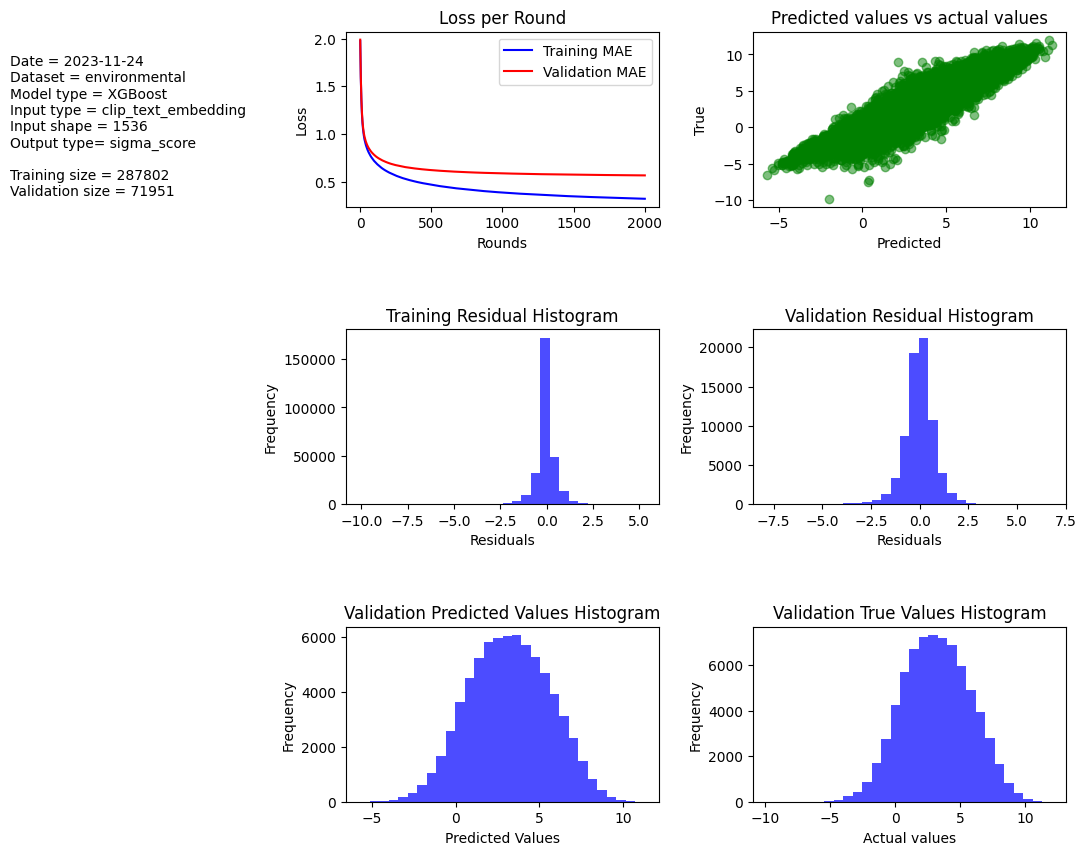

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
        
#info text about the model
plt.figtext(
    0.02, 0.7, "Date = {}\n"
    "Dataset = {}\n"
    "Model type = {}\n"
    "Input type = {}\n"
    "Input shape = {}\n"
    "Output type= {}\n\n"
    ""
    "Training size = {}\n"
    "Validation size = {}\n".format(
        datetime.now().strftime("%Y-%m-%d"),
        'environmental',
        'XGBoost',
        'clip_text_embedding',
        '1536',
        'sigma_score',
        Xtr.shape[0],
        Xvl.shape[0],
    )
)

# Plot validation and training Rmse vs. Rounds
axs[0][0].plot(range(1, len(train_mae) + 1), train_mae,'b', label='Training mae')
axs[0][0].plot(range(1, len(val_mae) + 1), val_mae,'r', label='Validation mae')
axs[0][0].set_title('Loss per Round')
axs[0][0].set_ylabel('Loss')
axs[0][0].set_xlabel('Rounds')
axs[0][0].legend(['Training MAE', 'Validation MAE'])

# Scatter Plot of actual values vs predicted values
axs[0][1].scatter(val_preds, yvl.squeeze(-1), color='green', alpha=0.5)
axs[0][1].set_title('Predicted values vs actual values')
axs[0][1].set_ylabel('True')
axs[0][1].set_xlabel('Predicted')

# plot histogram of training residuals
axs[1][0].hist(train_residuals, bins=30, color='blue', alpha=0.7)
axs[1][0].set_xlabel('Residuals')
axs[1][0].set_ylabel('Frequency')
axs[1][0].set_title('Training Residual Histogram')

# plot histogram of validation residuals
axs[1][1].hist(val_residuals, bins=30, color='blue', alpha=0.7)
axs[1][1].set_xlabel('Residuals')
axs[1][1].set_ylabel('Frequency')
axs[1][1].set_title('Validation Residual Histogram')

# plot histogram of predicted values
axs[2][0].hist(val_preds, bins=30, color='blue', alpha=0.7)
axs[2][0].set_xlabel('Predicted Values')
axs[2][0].set_ylabel('Frequency')
axs[2][0].set_title('Validation Predicted Values Histogram')

# plot histogram of true values
axs[2][1].hist(yvl.squeeze(-1), bins=30, color='blue', alpha=0.7)
axs[2][1].set_xlabel('Actual values')
axs[2][1].set_ylabel('Frequency')
axs[2][1].set_title('Validation True Values Histogram')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.7, wspace=0.3, left=0.3)
plt.show()